# 有监督算法之K近邻

背景：在Excel中存有Airbnb上面的租房信息，根据这些信息来判断当我有房子要出租时，租多少钱比较合理

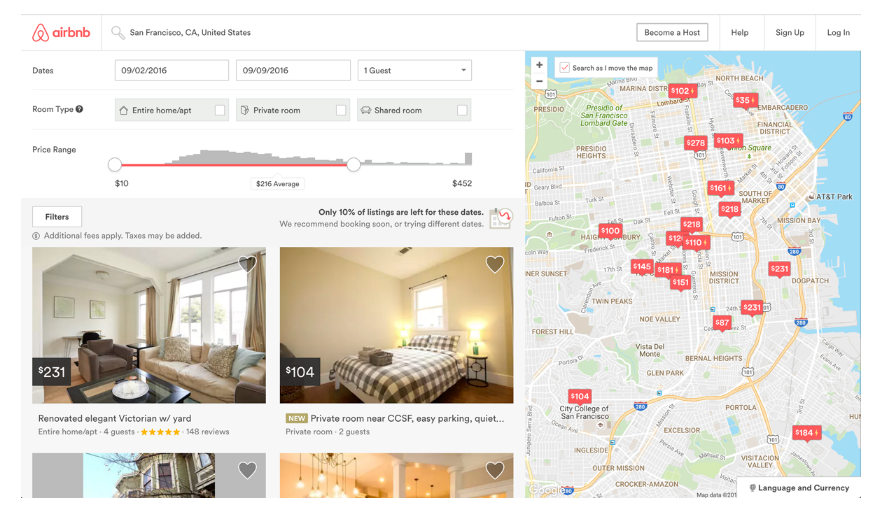

## 示例1

**读取数据**

In [1]:
import pandas as pd

features = ['accommodates','bedrooms','bathrooms','beds','price','minimum_nights','maximum_nights','number_of_reviews']
dc_listings = pd.read_csv('listings.csv')  #读取excel文件
dc_listings = dc_listings[features]   #根据指定字段过滤
print(dc_listings.shape)  #打印行和列
dc_listings.head()  #读取前5条数据

(3723, 8)


,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,4,1.0,1.0,2.0,$160.00,1,1125,0
1,6,3.0,3.0,3.0,$350.00,2,30,65
2,1,1.0,2.0,1.0,$50.00,2,1125,1
3,2,1.0,1.0,1.0,$95.00,1,1125,0
4,4,1.0,1.0,1.0,$50.00,7,1125,0


**K近邻算法**

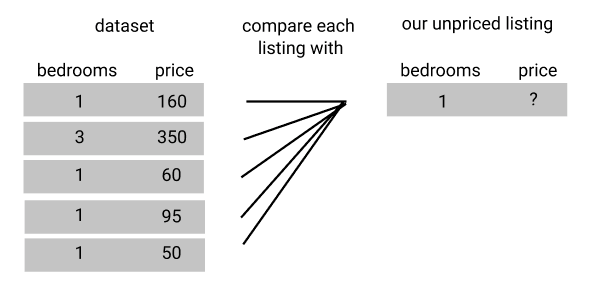

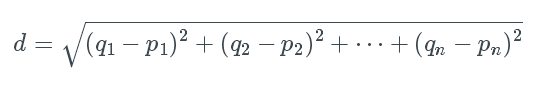

In [2]:
import numpy as np

our_acc_value=3    #假设我要出租的房子是一个三居室
dc_listings['distance'] = np.abs(dc_listings.accommodates - our_acc_value)  #根据K近邻算法，找到卧室数量最接近3个的数据
dc_listings.distance.value_counts().sort_index()  #计算出 每种卧室数量的房间数，并排序

0      461
1     2294
2      503
3      279
4       35
5       73
6       17
7       22
8        7
9       12
10       2
11       4
12       6
13       8
Name: distance, dtype: int64

**距离为0的有461,下面对这461条数据进行洗牌(sample)即打乱顺序**

In [3]:
dc_listings = dc_listings.sample(frac=1,random_state=0)  #将数据顺序打乱
dc_listings = dc_listings.sort_values('distance')  #根据 distance字段排序
dc_listings.price.head()  #取出 前5条数据

2645     $75.00
2825    $120.00
2145     $90.00
2541     $50.00
3349    $105.00
Name: price, dtype: object

**去掉美元符号，计算平均值。**

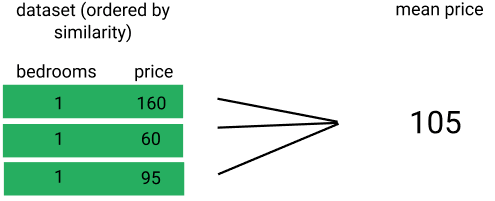

In [4]:
dc_listings['price'] = dc_listings.price.str.replace("\$|,",'').astype(float)   #去掉美元符号，并转换成float类型

mean_price = dc_listings.price.iloc[:5].mean()   #截取前5条数据并计算平均值
mean_price

88.0

## 示例2

**往往我们会将一些数据分成两部分，比如75%用来当作训练集，另外25%用来当作测试集。**

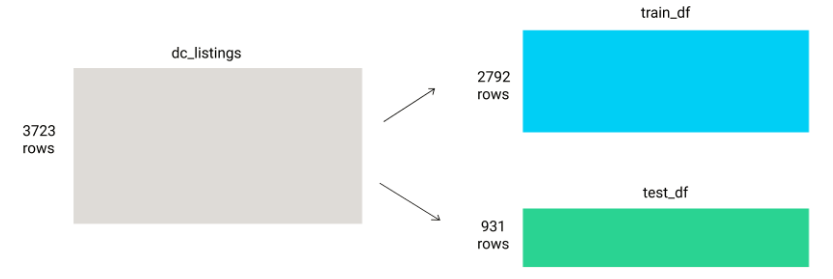

**首先制定好训练集和测试集**

In [5]:
dc_listings.drop('distance',axis=1)  #首先删除刚刚加入的distance这个字段，axis默认为0代表行，1代表列
train_df = dc_listings.copy().iloc[:2792]  # 数据总数为3723选2792条数据作为训练数据
test_df = dc_listings.copy().iloc[2792:] # 选剩下的数据作为测试数据

**基于单变量预测价格**

In [6]:
def predict_price(new_listing_value,feature_column):   # new_listing_value 测试集的指定字段的值
    temp_df = train_df 
    temp_df['distance'] = np.abs(dc_listings[feature_column] - new_listing_value)  # 根据训练集的字段 feature_column 求K邻近值
    temp_df = temp_df.sort_values('distance')  # 根据临近值的结果排序
    knn_5 = temp_df.price.iloc[:5]   # 取出最临近的前5条数据的 price字段的值
    predicted_price = knn_5.mean()  # 求这些price的平均值
    return (predicted_price)

**得到测试集中的预测结果**

In [7]:
test_df['predicted_price'] = test_df.accommodates.apply(predict_price,feature_column='accommodates')  # 将数据集的每一条数据都传入函数predict_price中计算

但是预测结果一定准确么？ 我们可以通过均方根误差公式来看我们的结果是否准确

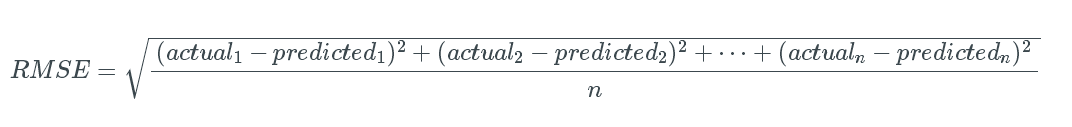

由于测试集中是存在真实的房价信息的，我们使用真实的价格减去预测的价格求出来的值的平方，这样算出来的n条数据的值加起来再除n，再开平方得到的就是RMSE

In [8]:
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)   # 公式的分母部分
mse = test_df['squared_error'].mean() # 分母除分子
rmse = mse ** (1/2) # 开根
rmse   # 均方根误差

212.98927967051543

**显然通过房间数量来进行结果预测误差太大了,我们需要对比查看一下通过其他特征进行预测的误差值**

In [9]:
for feature in ['accommodates','bedrooms','bathrooms','number_of_reviews']:  # 循环将每一个特征传入
    test_df['predicted_price'] = test_df[feature].apply(predict_price,feature_column=feature)
    
    test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)   # 公式的分母部分
    mse = test_df['squared_error'].mean() # 分母除分子
    rmse = mse ** (1/2) # 开根
    rmse   # 均方根误差
    print("RMSE for the {} column: {}".format(feature,rmse))

RMSE for the accommodates column: 212.98927967051543
RMSE for the bedrooms column: 199.80935328065033
RMSE for the bathrooms column: 230.24716705684227
RMSE for the number_of_reviews column: 235.91327066995507


**可以看出结果差异很大,但单哪一个特征值去预测都与实际结果相差甚远
所以我们需要根据多个字段来进行参考**

# 示例三，多变量KNN模型

**如果考虑到多变量即多字段的情况在计算euclidean距离的时候字段值大的字段对结果的影响会远远多于字段值小的字段
我们通过sklearn.preprocessing包中的StandardScaler 可以将数据标准化即缩小不同字段之间的值大小的差距**

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler  

features = ['accommodates','bedrooms','bathrooms','beds','price','minimum_nights','maximum_nights','number_of_reviews']

dc_listings = pd.read_csv('listings.csv')  # 读文本
 
dc_listings = dc_listings[features]   # 过滤出指定列   

dc_listings['price'] = dc_listings.price.str.replace("\$|,",'').astype(float)  # 去美元符号，将str转float

dc_listings = dc_listings.dropna()   # 滤除所有包含NaN的行

dc_listings[features] = StandardScaler().fit_transform(dc_listings[features])  # 用每条数据减去对应列的均值的结果再除以标准差，
                                                                               # 目的是每列数据值大小相近
normalized_listings = dc_listings

print(dc_listings.shape)

normalized_listings.head()

(3671, 8)


,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
0,0.401420,-0.249501,-0.439211,0.297386,0.081119,-0.341421,-0.016575,-0.516779
1,1.399466,2.129508,2.969551,1.141704,1.462622,-0.065047,-0.016606,1.706767
2,-1.095648,-0.249501,1.265170,-0.546933,-0.718699,-0.065047,-0.016575,-0.482571
3,-0.596625,-0.249501,-0.439211,-0.546933,-0.391501,-0.341421,-0.016575,-0.516779
4,0.401420,-0.249501,-0.439211,-0.546933,-0.718699,1.316824,-0.016575,-0.516779


In [11]:
norm_train_df = normalized_listings.copy().iloc[0:2792]
norm_test_df = normalized_listings.copy().iloc[2792:]

**多变量距离计算**

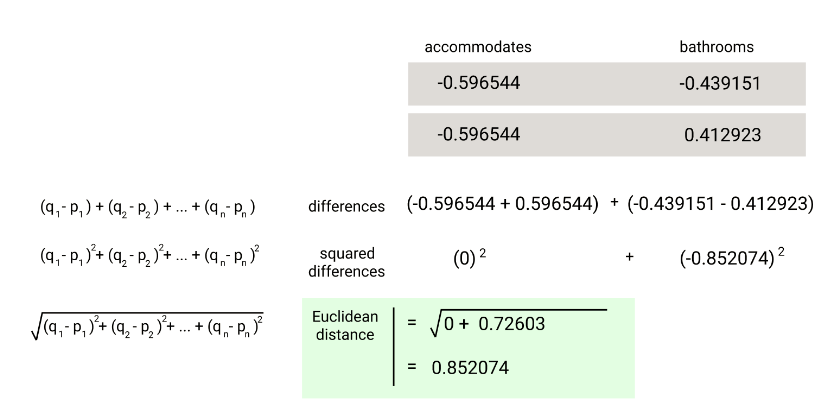

scipy中已经有现成的距离计算公式了,所以我们无需自己去计算欧式距离了，如下

In [12]:
from scipy.spatial import distance

first_listing = normalized_listings.iloc[0][['accommodates', 'bathrooms']]
fifth_listing = normalized_listings.iloc[20][['accommodates', 'bathrooms']]
first_fifth_distance = distance.euclidean(first_listing, fifth_listing)
first_fifth_distance

3.723019604017032

In [13]:
def predict_price_multivariate(new_listing_value,feature_columns):  # 预测价钱
    temp_df = norm_train_df
    temp_df['distance'] = distance.cdist(temp_df[feature_columns],[new_listing_value[feature_columns]])   # cdist函数有一个默认参数metric，默认值为euclidean
    temp_df = temp_df.sort_values('distance') 
    knn_5 = temp_df.price.iloc[:5]
    predicted_price = knn_5.mean()
    return(predicted_price)

cols = ['accommodates', 'bathrooms']
norm_test_df['predicted_price'] = norm_test_df[cols].apply(predict_price_multivariate,feature_columns=cols,axis=1)    
norm_test_df['squared_error'] = (norm_test_df['predicted_price'] - norm_test_df['price'])**(2)   # 计算误差
mse = norm_test_df['squared_error'].mean()
rmse = mse ** (1/2)
print(rmse)   

0.7894063922577537


# 示例四，使用Sklearn来完成KNN

Sklearn将我们之前自己做的计算欧式距离，然后取离测试数据最近的进行平均值计算这些操作都封装了，并提供了计算误差的函数。

In [17]:
from sklearn.neighbors import KNeighborsRegressor
cols = ['accommodates','bedrooms']
knn = KNeighborsRegressor()
knn.fit(norm_train_df[cols], norm_train_df['price'])   # 找临近值
two_features_predictions = knn.predict(norm_test_df[cols])  # 进行计算

In [18]:
from sklearn.metrics import mean_squared_error

two_features_mse = mean_squared_error(norm_test_df['price'], two_features_predictions)   # 计算误差
two_features_rmse = two_features_mse ** (1/2)
print(two_features_rmse)

0.8426824704818202


如下我们加入更多的特征值

In [19]:
knn = KNeighborsRegressor()

cols = ['accommodates','bedrooms','bathrooms','beds','minimum_nights','maximum_nights','number_of_reviews']

knn.fit(norm_train_df[cols], norm_train_df['price'])  # 找临近值
four_features_predictions = knn.predict(norm_test_df[cols])  # 进行计算
four_features_mse = mean_squared_error(norm_test_df['price'], four_features_predictions)  # 计算误差
four_features_rmse = four_features_mse ** (1/2)
four_features_rmse

0.8243838530880285